# Dynamical Systems and Brain-Inspired Computing

This tutorial explores **Dynamics** modules in BrainState, which are essential for brain-inspired computing and modeling continuous-time systems.

You will learn:

- 🧮 **Dynamics Base Class** - Framework for differential equations
- ⚡ **Exponential Euler Method** - Efficient numerical integration
- ⏱️ **Delay Systems** - Modeling delayed interactions
- 🎯 **Event-Driven Computation** - Sparse, efficient updates
- 🧠 **Brain-Inspired Models** - Spiking neurons and networks

## Why Dynamics?

Dynamical systems are fundamental to:
- 🧠 Neuroscience - Modeling biological neurons
- 🤖 Robotics - Continuous control systems
- 🔬 Physics simulations - Differential equations
- 📊 Signal processing - Temporal filtering

In [1]:
import brainstate
import jax.numpy as jnp
import matplotlib.pyplot as plt

## 1. Dynamics Base Class

The `Dynamics` class provides a framework for implementing systems governed by differential equations:

**dV/dt = f(V, t, I)**

### Simple Leaky Integrator

In [2]:
class LeakyIntegrator(brainstate.nn.Dynamics):
    """Leaky integrator: dV/dt = (-V + I) / tau"""
    
    def __init__(self, size, tau=10.0, dt=0.1):
        super().__init__(size)
        self.size = size
        self.tau = tau
        self.dt = dt
        
        # State variable
        self.V = brainstate.HiddenState(jnp.zeros(size))
    
    def derivative(self, V, t, I):
        """Compute dV/dt."""
        return (-V + I) / self.tau

    @brainstate.transform.jit(static_argnums=0)
    def update(self, I):
        """Update using Euler method."""
        dV = self.derivative(self.V.value, 0, I)
        self.V.value = self.V.value + self.dt * dV
        return self.V.value

# Create integrator
integrator = LeakyIntegrator(size=1, tau=10.0, dt=0.1)

print("Leaky Integrator:")
print(integrator)
print(f"\nState shape: {integrator.V.value.shape}")
print(f"Time constant τ: {integrator.tau}")
print(f"Time step dt: {integrator.dt}")

Leaky Integrator:
LeakyIntegrator(
  in_size=(1,),
  out_size=(1,),
  size=1,
  tau=10.0,
  dt=0.1,
  V=HiddenState(
    value=ShapedArray(float32[1])
  )
)

State shape: (1,)
Time constant τ: 10.0
Time step dt: 0.1


### Simulating the Integrator

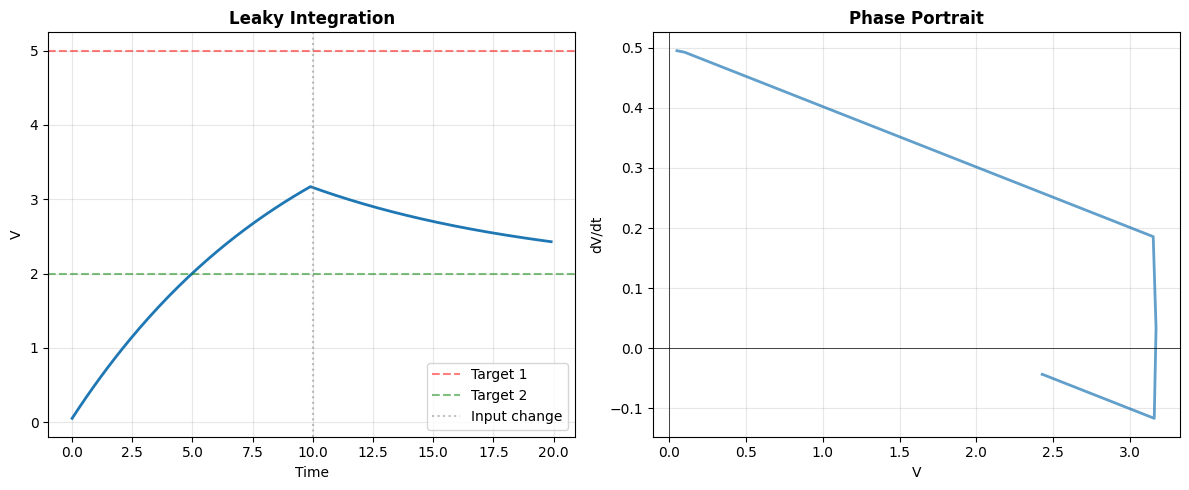

✅ Leaky integrator exponentially approaches input value
   Time constant determines speed: τ = 10.0


In [3]:
# Reset state
integrator.V.value = jnp.zeros(1)

# Simulate with step input
n_steps = 200
I_input = jnp.ones(1) * 5.0  # Constant input

trajectory = []
for t in range(n_steps):
    # Change input halfway
    if t == 100:
        I_input = jnp.ones(1) * 2.0
    
    V = integrator.update(I_input)
    trajectory.append(V[0])

trajectory = jnp.array(trajectory)
time = jnp.arange(n_steps) * integrator.dt

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time, trajectory, linewidth=2)
plt.axhline(5.0, color='red', linestyle='--', alpha=0.5, label='Target 1')
plt.axhline(2.0, color='green', linestyle='--', alpha=0.5, label='Target 2')
plt.axvline(10, color='gray', linestyle=':', alpha=0.5, label='Input change')
plt.xlabel('Time')
plt.ylabel('V')
plt.title('Leaky Integration', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Phase plot
plt.subplot(1, 2, 2)
dV_dt = jnp.gradient(trajectory) / integrator.dt
plt.plot(trajectory, dV_dt, linewidth=2, alpha=0.7)
plt.xlabel('V')
plt.ylabel('dV/dt')
plt.title('Phase Portrait', fontweight='bold')
plt.grid(alpha=0.3)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

print("✅ Leaky integrator exponentially approaches input value")
print(f"   Time constant determines speed: τ = {integrator.tau}")

## 2. Exponential Euler Method

For linear differential equations, the exponential Euler method is more accurate and stable:

**V(t+dt) = V(t) * exp(-dt/τ) + I * (1 - exp(-dt/τ))**

### Implementing Exponential Euler

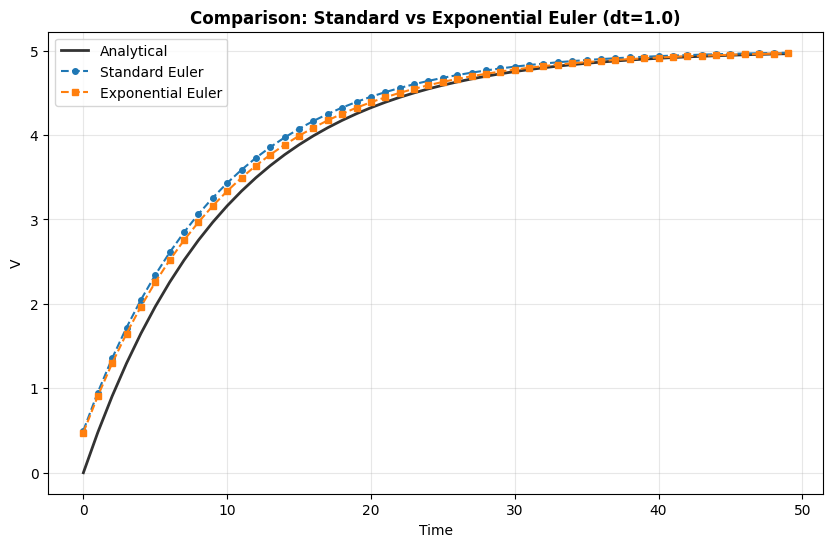

Mean Absolute Error:
  Standard Euler:     0.148391
  Exponential Euler:  0.099326

✅ Exponential Euler is exact for linear ODEs!
✅ More stable with larger time steps


In [4]:
class ExpEulerIntegrator(brainstate.nn.Dynamics):
    """Leaky integrator using exponential Euler method."""
    
    def __init__(self, size, tau=10.0, dt=0.1):
        super().__init__(size)
        self.size = size
        self.tau = tau
        self.dt = dt
        
        # Pre-compute integration constants
        self.exp_factor = jnp.exp(-dt / tau)
        self.int_factor = 1.0 - self.exp_factor
        
        # State
        self.V = brainstate.HiddenState(jnp.zeros(size))

    @brainstate.transform.jit(static_argnums=0)
    def update(self, I):
        """Update using exponential Euler."""
        self.V.value = self.V.value * self.exp_factor + I * self.int_factor
        return self.V.value

# Compare with standard Euler
euler_int = LeakyIntegrator(size=1, tau=10.0, dt=1.0)  # Large dt
exp_euler_int = ExpEulerIntegrator(size=1, tau=10.0, dt=1.0)

# Reset
euler_int.V.value = jnp.zeros(1)
exp_euler_int.V.value = jnp.zeros(1)

# Simulate
n_steps = 50
I = jnp.ones(1) * 5.0

traj_euler = []
traj_exp_euler = []

for t in range(n_steps):
    traj_euler.append(euler_int.update(I)[0])
    traj_exp_euler.append(exp_euler_int.update(I)[0])

# Analytical solution
time = jnp.arange(n_steps) * 1.0
analytical = I[0] * (1 - jnp.exp(-time / 10.0))

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(time, analytical, 'k-', linewidth=2, label='Analytical', alpha=0.8)
plt.plot(time, traj_euler, 'o--', label='Standard Euler', markersize=4)
plt.plot(time, traj_exp_euler, 's--', label='Exponential Euler', markersize=4)
plt.xlabel('Time')
plt.ylabel('V')
plt.title('Comparison: Standard vs Exponential Euler (dt=1.0)', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Compute errors
error_euler = jnp.mean(jnp.abs(jnp.array(traj_euler) - analytical))
error_exp_euler = jnp.mean(jnp.abs(jnp.array(traj_exp_euler) - analytical))

print(f"Mean Absolute Error:")
print(f"  Standard Euler:     {error_euler:.6f}")
print(f"  Exponential Euler:  {error_exp_euler:.6f}")
print(f"\n✅ Exponential Euler is exact for linear ODEs!")
print(f"✅ More stable with larger time steps")

## 3. Leaky Integrate-and-Fire Neuron

A classic spiking neuron model:

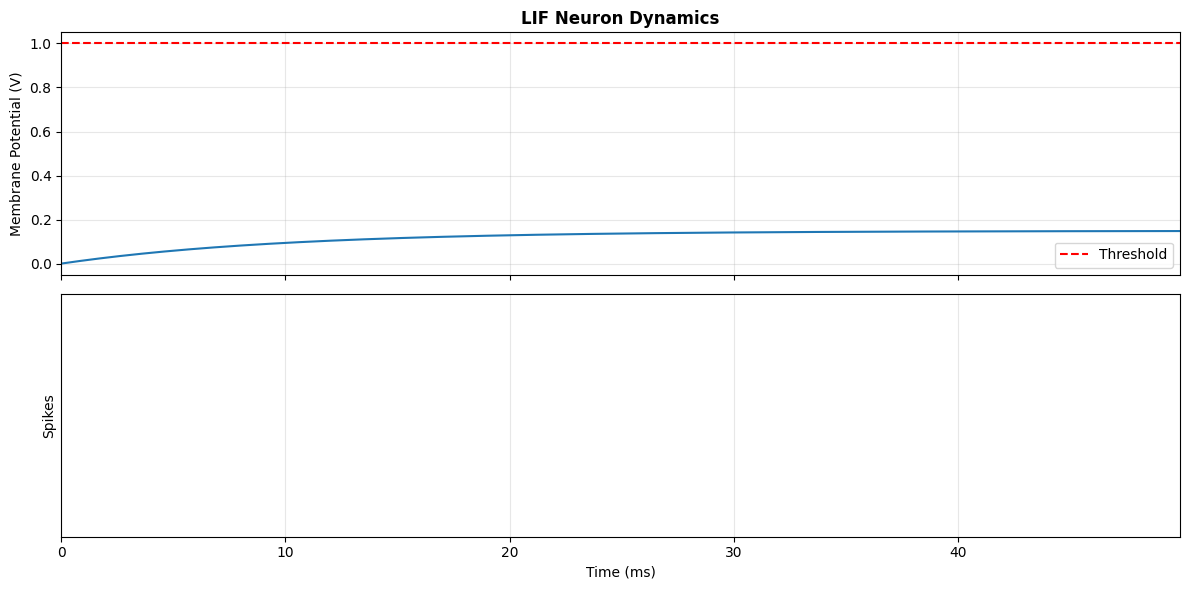

Firing rate: 0.00 Hz
Interspike interval: inf ms


In [5]:
class LIFNeuron(brainstate.nn.Dynamics):
    """Leaky Integrate-and-Fire neuron."""
    
    def __init__(self, size, tau=10.0, V_th=1.0, V_reset=0.0, dt=0.1):
        super().__init__(size)
        self.size = size
        self.tau = tau
        self.V_th = V_th
        self.V_reset = V_reset
        self.dt = dt
        
        # Integration constants
        self.exp_factor = jnp.exp(-dt / tau)
        self.int_factor = 1.0 - self.exp_factor
        
        # States
        self.V = brainstate.HiddenState(jnp.full(size, V_reset))
        self.spike = brainstate.ShortTermState(jnp.zeros(size, dtype=bool))
    
    def update(self, I):
        """Update neuron state."""
        # Integrate
        self.V.value = self.V.value * self.exp_factor + I * self.int_factor
        
        # Spike detection
        self.spike.value = self.V.value >= self.V_th
        
        # Reset
        self.V.value = jnp.where(self.spike.value, self.V_reset, self.V.value)
        
        return self.spike.value

# Create neuron
neuron = LIFNeuron(size=1, tau=10.0, V_th=1.0, V_reset=0.0, dt=0.1)

# Simulate with constant input
n_steps = 500
I_input = jnp.ones(1) * 0.15

voltages = []
spikes = []

for t in range(n_steps):
    spike = neuron.update(I_input)
    voltages.append(neuron.V.value[0])
    spikes.append(spike[0])

voltages = jnp.array(voltages)
spikes = jnp.array(spikes)
time = jnp.arange(n_steps) * neuron.dt

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Membrane potential
axes[0].plot(time, voltages, linewidth=1.5)
axes[0].axhline(neuron.V_th, color='red', linestyle='--', label='Threshold')
axes[0].set_ylabel('Membrane Potential (V)')
axes[0].set_title('LIF Neuron Dynamics', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Spike raster
spike_times = time[spikes]
axes[1].eventplot(spike_times, colors='black', linewidths=2)
axes[1].set_ylabel('Spikes')
axes[1].set_xlabel('Time (ms)')
axes[1].set_xlim([0, time[-1]])
axes[1].set_ylim([0.5, 1.5])
axes[1].set_yticks([])
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Compute firing rate
firing_rate = jnp.sum(spikes) / (n_steps * neuron.dt) * 1000  # Hz
print(f"Firing rate: {firing_rate:.2f} Hz")
print(f"Interspike interval: {1000/firing_rate:.2f} ms")

## 4. Delay Systems

Delays are common in neural systems due to synaptic and axonal transmission delays.

BrainState provides `brainstate.nn.Delay` for efficient delay management.

### Using brainstate.nn.Delay

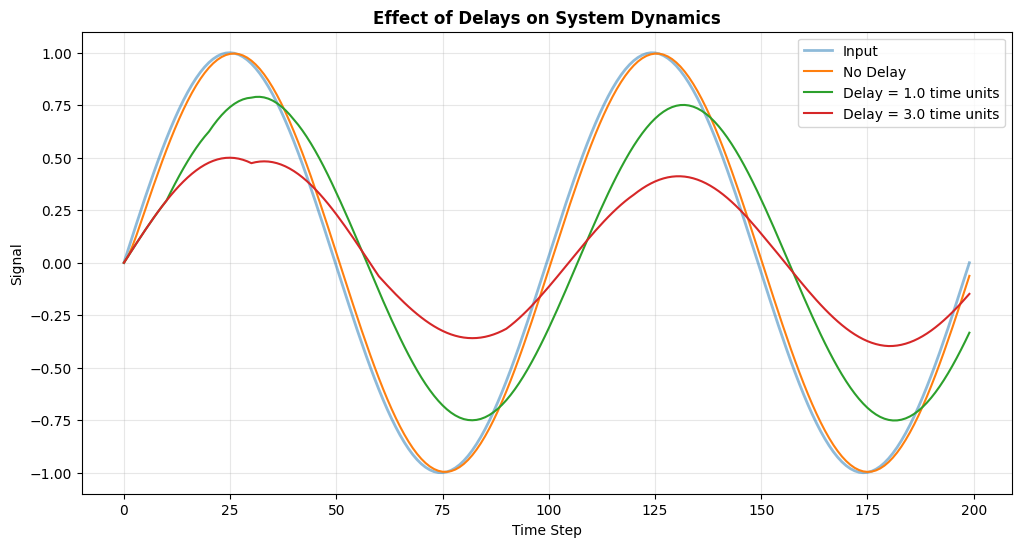

✅ brainstate.nn.Delay efficiently manages delay buffers
✅ Delays create phase shifts and affect system stability
   Common in neural networks due to transmission delays


In [7]:
class DelayedSystem(brainstate.nn.Module):
    """System with delayed feedback using brainstate.nn.Delay."""
    
    def __init__(self, delay_time=1.0, dt=0.1):
        super().__init__()
        self.dt = dt
        
        # Current state
        self.x = brainstate.HiddenState(jnp.array(0.0))
        
        # Create delay with proper target info
        target_info = jnp.array(0.0)  # Shape and dtype info
        self.delay = brainstate.nn.Delay(
            target_info=target_info,
            time=delay_time,
            init=0.0,  # Initial delay buffer values
            entries={'delayed_x': delay_time}  # Register delay entry
        )
        
        # Initialize delay state
        self.delay.init_state()
    
    def update(self, input_signal):
        """Update with delayed feedback."""
        # Get delayed value
        delayed_value = self.delay.at('delayed_x')
        
        # Update current state with delayed feedback
        self.x.value = 0.5 * (input_signal + delayed_value)
        
        # Update delay buffer with current value
        self.delay.update(self.x.value)
        
        return self.x.value

# Test with different delays
n_steps = 200
input_signal = jnp.sin(jnp.linspace(0, 4 * jnp.pi, n_steps))

# Create environment for time stepping
brainstate.environ.set(dt=0.1)

# No delay
brainstate.environ.set(i=0)
sys_nodelay = DelayedSystem(delay_time=0.0, dt=0.1)
output_nodelay = []
for i, inp in enumerate(input_signal):
    brainstate.environ.set(i=i)
    output_nodelay.append(sys_nodelay.update(inp))

# Short delay
brainstate.environ.set(i=0)
sys_short = DelayedSystem(delay_time=1.0, dt=0.1)
output_short = []
for i, inp in enumerate(input_signal):
    brainstate.environ.set(i=i)
    output_short.append(sys_short.update(inp))

# Long delay
brainstate.environ.set(i=0)
sys_long = DelayedSystem(delay_time=3.0, dt=0.1)
output_long = []
for i, inp in enumerate(input_signal):
    brainstate.environ.set(i=i)
    output_long.append(sys_long.update(inp))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(input_signal, label='Input', linewidth=2, alpha=0.5)
plt.plot(output_nodelay, label='No Delay', linewidth=1.5)
plt.plot(output_short, label='Delay = 1.0 time units', linewidth=1.5)
plt.plot(output_long, label='Delay = 3.0 time units', linewidth=1.5)
plt.xlabel('Time Step')
plt.ylabel('Signal')
plt.title('Effect of Delays on System Dynamics', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("✅ brainstate.nn.Delay efficiently manages delay buffers")
print("✅ Delays create phase shifts and affect system stability")
print("   Common in neural networks due to transmission delays")

## 5. Network of LIF Neurons

Let's build a small network of interconnected spiking neurons:

LIF Network:
  Neurons: 50
  Connections: 230
  Connection density: 9.20%


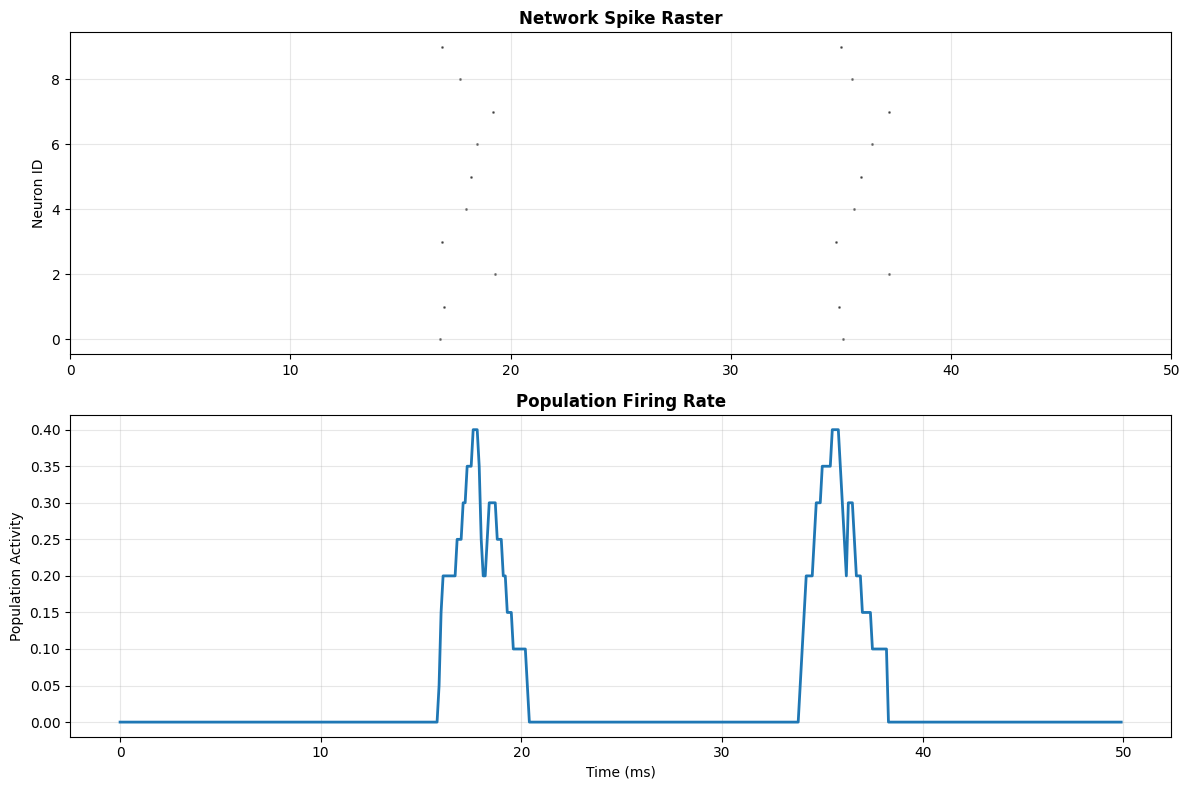


Total spikes: 20
Mean firing rate: 8.00 Hz


In [9]:
class LIFNetwork(brainstate.nn.Dynamics):
    """Network of LIF neurons."""
    
    def __init__(self, n_neurons, connection_prob=0.2, dt=0.1):
        super().__init__(n_neurons)
        self.n_neurons = n_neurons
        self.dt = dt
        
        # Neuron parameters
        tau = 10.0
        self.exp_factor = jnp.exp(-dt / tau)
        self.int_factor = 1.0 - self.exp_factor
        
        # States
        self.V = brainstate.HiddenState(brainstate.random.randn(n_neurons) * 0.1)
        self.spike = brainstate.ShortTermState(jnp.zeros(n_neurons, dtype=bool))
        
        # Random connectivity
        brainstate.random.seed(42)
        W = brainstate.random.randn(n_neurons, n_neurons) * 0.1
        mask = brainstate.random.rand(n_neurons, n_neurons) < connection_prob
        W = W * mask
        W = W - jnp.diag(jnp.diag(W))  # No self-connections
        self.W = brainstate.ParamState(W)

    @brainstate.transform.jit(static_argnums=0)
    def update(self, I_ext):
        """Update network."""
        # Synaptic input from network
        I_syn = self.W.value @ self.spike.value.astype(float)
        
        # Total input
        I_total = I_ext + I_syn
        
        # Integrate
        self.V.value = self.V.value * self.exp_factor + I_total * self.int_factor
        
        # Spike and reset
        self.spike.value = self.V.value >= 1.0
        self.V.value = jnp.where(self.spike.value, 0.0, self.V.value)
        
        return self.spike.value

# Create network
network = LIFNetwork(n_neurons=50, connection_prob=0.1)

print(f"LIF Network:")
print(f"  Neurons: {network.n_neurons}")
print(f"  Connections: {jnp.sum(network.W.value != 0)}")
print(f"  Connection density: {jnp.mean(network.W.value != 0):.2%}")

# Simulate
n_steps = 500
spike_history = []

for t in range(n_steps):
    # External input to first 10 neurons
    I_ext = jnp.zeros(50)
    I_ext = I_ext.at[:10].set(1.2 + 0.1 * brainstate.random.randn(10))

    spikes = network.update(I_ext)
    spike_history.append(spikes)

spike_history = jnp.array(spike_history)

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Raster plot
spike_times, spike_neurons = jnp.where(spike_history)
axes[0].scatter(spike_times * network.dt, spike_neurons, s=1, color='black', alpha=0.5)
axes[0].set_ylabel('Neuron ID')
axes[0].set_title('Network Spike Raster', fontweight='bold')
axes[0].set_xlim([0, n_steps * network.dt])
axes[0].grid(alpha=0.3)

# Population firing rate
window = 20
pop_rate = jnp.convolve(jnp.sum(spike_history, axis=1), 
                        jnp.ones(window)/window, mode='same')
time = jnp.arange(n_steps) * network.dt
axes[1].plot(time, pop_rate, linewidth=2)
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Population Activity')
axes[1].set_title('Population Firing Rate', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal spikes: {jnp.sum(spike_history)}")
print(f"Mean firing rate: {jnp.sum(spike_history) / (n_steps * network.dt * network.n_neurons) * 1000:.2f} Hz")

## Summary

In this tutorial, you learned:

✅ **Dynamics Framework**
  - Implementing differential equations
  - Numerical integration methods
  - State management in dynamical systems

✅ **Exponential Euler Method**
  - Exact for linear ODEs
  - More stable than standard Euler
  - Efficient for neural dynamics

✅ **Spiking Neurons**
  - Leaky Integrate-and-Fire model
  - Threshold detection and reset
  - Firing rate computation

✅ **Delay Systems**
  - Implementing delays with circular buffers
  - Impact of delays on dynamics
  - Synaptic transmission delays

✅ **Spiking Neural Networks**
  - Network connectivity
  - Recurrent dynamics
  - Population activity patterns

### Key Concepts

| Concept | Description | Use Case |
|---------|-------------|----------|
| **Dynamics** | Base class for ODEs | Any time-dependent system |
| **ExpEuler** | Exact for linear ODEs | Neural dynamics, RC circuits |
| **LIF** | Spiking neuron model | Brain-inspired computing |
| **Delays** | Temporal offsets | Synaptic delays, control systems |

### Best Practices

1. ⚡ **Use ExpEuler** for linear differential equations
2. 📊 **Choose appropriate dt** - Balance accuracy and speed
3. 🔍 **Monitor stability** - Check for numerical instabilities
4. 🎯 **Validate against theory** - Compare with analytical solutions
5. 💾 **Save trajectories** - Useful for analysis and debugging

### Applications

- 🧠 **Computational Neuroscience**: Spiking neural networks
- 🤖 **Neuromorphic Computing**: Event-driven processing
- 🎮 **Continuous Control**: Robotics, games
- 📈 **Signal Processing**: Temporal filtering
- 🔬 **Physics Simulations**: Any system with ODEs

### Next Steps

Now you've completed the Neural Networks tutorial series!

Continue with:
- **Program Transformations** - JIT, vmap, grad for optimization
- **Training Loops** - Build complete training pipelines
- **Advanced Models** - ResNets, Transformers, GANs

### Additional Resources

- 📚 [BrainState Documentation](https://brainstate.readthedocs.io/)
- 🧠 [BrainPy for Spiking Networks](https://brainpy.readthedocs.io/)
- 📖 [Neuronal Dynamics Book](https://neuronaldynamics.epfl.ch/)
- 🔬 [Computational Neuroscience](https://www.coursera.org/learn/computational-neuroscience)